In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import fileinput
import glob
import os
import shutil
pd.set_option('display.max_columns', None)

In [7]:
#################################
#### FUNCTIONS USED LATER #######
#################################
columns = ['sur', 'sur2', 't', 'e1','e2','g1','g2','a1','i1','i2','i','spin1h','spintot',
           'beta','vp','spin1e','spin1q','spin2e','spin2q','spin2h','htot','m1','R1','m2',
           'R2','a2','m3','Roche1','R1','type1','type2','type3','beta2','gamma','gamma2','flag']
def get_first_line(file_path): #get first line 
    with open(file_path) as f:
        return f.readline()

def get_last_line(file_path): #faster way to get last line
    with open(file_path, 'rb') as file:
        try:
            file.seek(-2, os.SEEK_END)
            while file.read(1) != b'\n':
                file.seek(-2, os.SEEK_CUR)
        except OSError:
            file.seek(0)
        last_line = file.readline().decode()
        return last_line
def maybe_float(s):
    try:
        return float(s)
    except (ValueError, TypeError):
        return s

def Kepler_3rdLaw(P,m1,m2):
    '''
    Function to get semi-major axis from period using K3L
    :param P: Period of orbit in **yr**
    :return: returns SMA (a) in **AU**
    '''
    G = 1.19e-19 #G in AU^3/M_sun*s^2
    a = np.power( ( (P**2)*(m1+m2) ) ,1./3.) #Kepler's Third Law
    return(a)
def Roche_limit(q):
    '''
    Function to get Roche Limit of specified mass ratios (q)
    :param q: mass ratio
    :return: returns the Roche Limit (RHS of Eqn.1 from Naoz+2014)
    '''
    num1,num2=0.49,0.6;
    return num1*np.power(q,2./3.)/(0.6* np.power(q,2./3.)+np.log(1+np.sqrt(q)));
def pos_normal(mean, sigma): 
    '''
    Function to get only positive values from normal distribution recursively
    '''
    x = np.random.normal(mean,sigma)
    return(x if x>=0 else pos_normal(mean,sigma))
def rndm(a, b, g, size=1):
    """Power-law gen for pdf(x)\propto x^{g-1} for a<=x<=b"""
    r = np.random.random(size=size)
    ag, bg = a**g, b**g
    return (ag + (bg - ag)*r)**(1./g)   
    
def initial_conditions():
    
    m1 = 1. #rndm(1.0,8.0,-1.35)[0] #Salpeter PDF
    #m1=1. #default m1= 1 M_sun
    
    q_in,q_out = pos_normal(0.23,0.42),pos_normal(0.23,0.42)
    
    m2 = m1*q_in
    m3 = q_out*(m1+m2)
    
    R1 = m1
    R2 = R1*np.power(m2/m1,4./5.)
    
    spin1P = 25.
    spin2P = 25.
    
    beta = np.random.uniform(0,180)
    beta2 = 0.
    
    gamma = 45.
    gamma2 = 45.
    
    g1 = np.random.uniform(0,360)
    g2 = np.random.uniform(0,360)
    
    age = 12.5*1e3 #*1.e6, means 10*1e9

    P_in,P_out = 10**np.random.normal(4.8,2.3), 10**np.random.normal(4.8,2.3) #periods in days
    P_in,P_out = P_in/365.25, P_out/365.25 #periods in yr
    
    a1,a2 = Kepler_3rdLaw(P_in,m1,m2), Kepler_3rdLaw(P_out,m1+m2,m3) #SMA in AU
    e1,e2 = np.random.uniform(0,1),np.random.uniform(0,1)

    #inclination
    cosi = np.random.uniform(np.cos(0),np.cos(np.pi))
    i = np.rad2deg(np.arccos(cosi))

    #stability_criteria from Mardling & Aarseth (2001),**BOOL**
    stable = 2.8 * np.power(1.+ q_out,2./5.) * np.power(1.+e2, 2./5.)*np.power(1.-e2, -6./5.)*(1-(0.3*i/180.)) 
        
    Roche1=Roche_limit(m1/m2);
    Roche2=Roche_limit(m2/m1);
    Rsun = (695500*6.68459e-9)  #sun radius in AU

    # BOOLEANS to check that parameters are **STABLE**
    stability_criteria = a2/a1 > stable
    Roche1_criteria = R1*Rsun < (a1*(1-e1)*Roche1)
    Roche2_criteria = R2*Rsun < (a1*(1-e1)*Roche2)
    mass_criteria = m1>0 and m2>0 and m3>0 #this condition should already be met bc pos_normal function
    criteria = (stability_criteria and mass_criteria and (Roche1_criteria and Roche2_criteria))

    # recurse if criteria are not met until criteria are met
    if criteria:
        return(np.array([m1,m2,m3,R1,R2,spin1P,spin2P,beta,beta2,gamma,gamma2,a1,a2,e1,e2,g1,g2,i,age]))
    else:
        return initial_conditions()
    

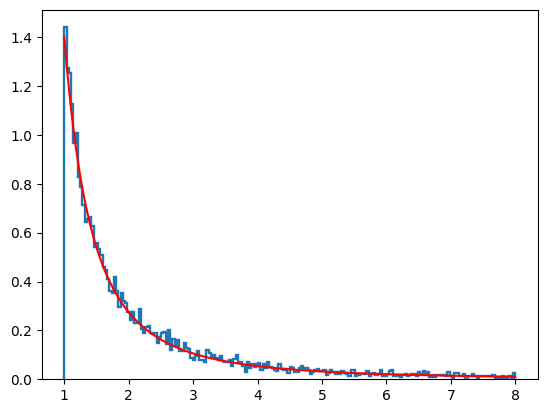

In [5]:
#SALPETER IMF
c=[]
x = np.linspace(1,8,1000)
y= 1.4*x**-2.35
for i in range(10000):
    c.append(rndm(1.0,8.0,-1.35)[0])
plt.hist(c,histtype='step',bins=200,linewidth=1.7,density=True)
plt.plot(x,y,c='r')


In [34]:
def Kepler_3rdLaw(P,m1,m2):
    '''
    Function to get semi-major axis from period using K3L
    :param P: Period of orbit in **yr**
    :return: returns SMA (a) in **AU**
    '''
    G = 1.19e-19 #G in AU^3/M_sun*s^2
    a = np.power( ( (P**2)*(m1+m2) ) ,1./3.) #Kepler's Third Law
    return(a)
def Roche_limit(q):
    '''
    Function to get Roche Limit of specified mass ratios (q)
    :param q: mass ratio
    :return: returns the Roche Limit (RHS of Eqn.1 from Naoz+2014)
    '''
    num1,num2=0.49,0.6;
    return num1*np.power(q,2./3.)/(0.6* np.power(q,2./3.)+np.log(1+np.sqrt(q)));
def pos_normal(mean, sigma): 
    '''
    Function to get only positive values from normal distribution recursively
    '''
    x = np.random.normal(mean,sigma)
    return(x if x>=0 else pos_normal(mean,sigma))
def rndm(a, b, g, size=1):
    """Power-law gen for pdf(x)\propto x^{g-1} for a<=x<=b"""
    r = np.random.random(size=size)
    ag, bg = a**g, b**g
    return (ag + (bg - ag)*r)**(1./g)   
    
def initial_conditions():
    
    m1 = 1#rndm(1.0,8.0,-1.35)[0] #Salpeter Prob Distribution
    q_in,q_out = pos_normal(0.23,0.42),pos_normal(0.23,0.42)
    
    m2 = m1*q_in
    m3 = q_out*(m1+m2)
    
    R1 = m1
    R2 = R1*np.power(m2/m1,4./5.)
    
    spin1P = 25.
    spin2P = 25.
    
    beta = np.random.uniform(0,180)
    beta2 = 0.
    
    gamma = 45.
    gamma2 = 45.
    
    g1 = np.random.uniform(0,360)
    g2 = np.random.uniform(0,360)
    
    age = 12.5*1e3 #*1.e6, means 10*1e9

    P_in,P_out = 10**np.random.normal(4.8,2.3), 10**np.random.normal(4.8,2.3) #periods in days
    P_in,P_out = P_in/365.25, P_out/365.25 #periods in yr
    
    a1,a2 = Kepler_3rdLaw(P_in,m1,m2), Kepler_3rdLaw(P_out,m1+m2,m3) #SMA in AU
    e1,e2 = np.random.uniform(0,1),np.random.uniform(0,1)

    #inclination
    cosi = np.random.uniform(np.cos(0),np.cos(np.pi))
    i = np.rad2deg(np.arccos(cosi))

    #stability_criteria from Mardling & Aarseth (2001),**BOOL**
    stable = 2.8 * np.power(1.+ q_out,2./5.) * np.power(1.+e2, 2./5.)*np.power(1.-e2, -6./5.)*(1-(0.3*i/180.)) 
        
    Roche1=Roche_limit(m1/m2);
    Roche2=Roche_limit(m2/m1);
    Rsun = (695500*6.68459e-9)  #sun radius in AU

    # BOOLEANS to check that parameters are **STABLE**
    stability_criteria = a2/a1 > stable
    Roche1_criteria = R1*Rsun < (a1*(1-e1)*Roche1)
    Roche2_criteria = R2*Rsun < (a1*(1-e1)*Roche2)
    mass_criteria = m1>0 and m2>0 and m3>0 #this condition should already be met bc pos_normal function
    criteria = (stability_criteria and mass_criteria and (Roche1_criteria and Roche2_criteria))

    # recurse if criteria are not met until criteria are met
    if criteria:
        return(np.array([m1,m2,m3,R1,R2,spin1P,spin2P,beta,beta2,gamma,gamma2,a1,a2,e1,e2,g1,g2,i,age]))
    else:
        return initial_conditions()
    

In [35]:
#############################################
##### FUNCTIONs THAT CREATES triple.in's #####
#############################################

#OSPE FLAGS; 0 (yes) 1 (no)
quadrupole = 0
octupole = 0
GR = 0
TF = 0
ML1 = 0
MB1 = 0
ML2 = 0
MB2 = 0
ML3 = 0
SSE1 = 0
SSE2 = 0
SSE3 = 0
tMSMyr = 0

# ==========================================================================

def create_file(initial_conditions, file_dir, file_end, eps = 1e-16, restart=False):
    """
    Function to create a triple.in file with input initial conditions
    :param initial_conditions: array of initial conditions from generate_inicon
    :param file_dir: directory to store triple.in files in
    :param file_end: file suffix (i.e. '1' to write triple.in1)
    :param start_time: system age to start simulations on
    :param restart: flag set to True if code is being re-started on Hoffman
    :return: writes a triple.inX file and saves to file_dir
    """
    # open new file
    filename = file_dir + '/' + 'triple.in' + file_end
    out = open(filename,'w')
    
    # write header
    out.write("#########################################################################\n")
    out.write("## Read in the initial orbital parameters of the triple system         ##\n")
    out.write("## Mass in M_sol, semimajor axis in AU                                 ##\n")
    out.write("#########################################################################\n")
    out.write("\n")
    
    if restart==False:
        out.write("__m1_______m2___________m3________R1(Rsun)____R2(Rsun)____Spin1P(day)__Spin2P(day)_ _beta(s_O_deg)__beta2(s_O_deg)__gamma(s_O_deg)__gamma2(s_O_deg)__a1______a2____e1____e2____g1(deg)__g2(deg)__i(deg)__age(Myr)___ :::\n")
    
    elif restart==True:
        out.write("__m1_______m2___________m3________R1(Rsun)____R2(Rsun)____Spin1P(day)__Spin2P(day)_    _beta(s_O_deg)__beta2(s_O_deg)__gamma(s_O_deg)__gamma2(s_O_deg)__a1______a2____e1____e2____g1(deg)__g2(deg)__i(deg)__t_i(yr)__age(Myr)___ :::\n")
        
    out.write("\n")
    
    # add initial conditions
    out.write('  '.join([str(i) for i in initial_conditions])+'\n')
    
    # add header for flags
    out.write("\n")
    out.write("#########################################################################\n")
    out.write("## Flags                                                               ##\n")
    
    # quadrupole
    out.write("#########################################################################\n")
    out.write("\n")
    out.write("__QUADRUPOLE(0_yes_1_no)___ :::\n")
    out.write(str(quadrupole)+'\n') # for quadrupole?
    out.write("\n")
    
    # octupole
    out.write("#########################################################################\n")
    out.write("__OCTUPOLE(0_yes_1_no)___ :::\n")
    out.write("\n")
    out.write(str(octupole)+'\n') # for octupole?
    out.write("\n")
    
    # GR
    out.write("#########################################################################\n")
    out.write("__GR(0_yes_1_no)___ :::\n")
    out.write("\n")
    out.write(str(GR)+'\n') # for GR?
    out.write("\n")
    
    # tidal forces
    out.write("#########################################################################\n")
    out.write("__TF(0_yes_1_no)___ :::\n")
    out.write("\n")
    out.write(str(TF)+'\n') #for TF?
    out.write("\n")
    
    out.write("########################################################################\n")
    out.write("__ML1(0_yes_1_no)___ :::\n")
    out.write("\n")
    out.write(str(ML1)+'\n') # for ML1?
    out.write("\n")
    
    out.write("########################################################################\n")
    out.write("__MB1(0_yes_1_no)___ :::\n")
    out.write("\n")
    out.write(str(MB1)+'\n') # for MB1?
    out.write("\n")
    
    out.write("########################################################################\n")
    out.write("__ML2(0_yes_1_no)___ :::\n")
    out.write("\n")
    out.write(str(ML2)+'\n') # for ML2?
    out.write("\n")
    
    out.write("########################################################################\n")
    out.write("__MB2(0_yes_1_no)___ :::\n")
    out.write("\n")
    out.write(str(MB2)+'\n') # for MB2?
    out.write("\n")
    
    out.write("########################################################################\n")
    out.write("__ML3(0_yes_1_no)___ :::\n")
    out.write("\n")
    out.write(str(ML3)+'\n') # for ML3?
    out.write("\n")
    
    out.write("########################################################################\n")
    out.write("__SSE1(0_yes_1_no)___ :::\n")
    out.write("\n")
    out.write(str(SSE1)+'\n') # for SSE1?
    out.write("\n")
    
    out.write("########################################################################\n")
    out.write("__SSE2(0_yes_1_no)___ :::\n")
    out.write("\n")
    out.write(str(SSE2)+'\n') # for SSE2?
    out.write("\n")
    
    out.write("########################################################################\n")
    out.write("__SSE3(0_yes_1_no)___ :::\n")
    out.write("\n")
    out.write(str(SSE3)+'\n') # for SSE3?
    out.write("\n")
    
    out.write("########################################################################\n")
    out.write("__tMSMyr(0_yes_1_no)___ :::\n")
    out.write("\n")
    out.write(str(tMSMyr)+'\n') # for tMSMyr?
    out.write("\n")
    
    # add control parameters section
    out.write("#########################################################################\n")
    out.write("## Control Parameters                                                  ##\n")
    out.write("#########################################################################\n")
    out.write("\n")
    out.write("__eps___ :::\n")
    out.write(str(eps)+"\n")
 #   out.write("1e-16\n")
    
    out.close()

    
############################################################
##### FUNCTION THAT CREATES N triple.in's TO DIRECTORY #####
############################################################
def generate_set_of_files(n, file_dir, start = 1):
    """
    Creates a set of triple.in files by iteratively running create_file()
    :param n: number of triple.in files to generate (will create triple.in1-n)
    :param file_dir: directory to store triple.in files in
    :return: writes a n triple.inX file and saves to file_dir
    """
    # for j in range(start,start+n+1):
    #     inicons = initial_conditions()
    #     file_end = str(j)
    #     print(initial_conditions)
    #     create_file(inicons, file_dir,file_end)

    n_files = start
    n_max = start + n
    while n_files < n_max:
        inicons = initial_conditions()
        
        
        file_end = str(n_files)
        create_file(inicons, file_dir, file_end)
        n_files += 1

In [36]:
# ==========================================================================
# RUNNING THE ABOVE FUNCTIONS TO GENERATE FILES 
n=1000
file_dir='/Users/bijan1339/Desktop/Research/ICs/'
generate_set_of_files(n,file_dir,start=7000)

In [233]:
(1000 <= int(n) <=1400 or 1500 <= int(n) <2000)

False

In [23]:
columns = ['sur', 'sur2', 't', 'e1','e2','g1','g2','a1','i1','i2','i','spin1h','spintot',
           'beta','vp','spin1e','spin1q','spin2e','spin2q','spin2h','htot','m1','R1','m2',
           'R2','a2','m3','Roche1','R1','type1','type2','type3','beta2','gamma','gamma2','flag']


AU = 1.496E13       # astronomical unit, cm 
Rsun = 6.96e10    # radius of sun, cm 
pi = np.pi          # pi, 

# need unfinished numbers and unfinished filenames
# loop_number = int(input('previous loop number: '))
# loop_str = '.loop'+str(loop_number)
# unfinished_filenames = sorted(glob.glob(output_dir+'Output/output_*.txt'+loop_str))
# unfinished_numbers = [fname[40:-10] for fname in unfinished_filenames]



outputs_directory = '/Users/bijan1339/Desktop/Research/Outputs/' #'/Users/bijan1339/Desktop/Research/Outputs/'
inicon_dir = '/Users/bijan1339/Desktop/Research/ICs/' #directory of where triple.in's are
zero_dir = '/Users/bijan1339/Desktop/Research/ICs_Zero/' #for files that didn't start (t=0 or filesize=0), just need to rerun these, no restart
restart_inicon_dir = '/Users/bijan1339/Desktop/Research/ICs_restart/' #where to put new restart triple.in's 
not_start=[]
unfinished_numbers=[]
restart_numbers=[]
for filename in os.listdir(outputs_directory):
    
    n = filename.split('_')[-1].split('.')[0]
    if (
        (filename.endswith('.txt') and filename.startswith('output') ) and 
        (1000 <= int(n) <=1400 or 1500 <= int(n) <2000)
        ):
        
        n = int(filename.split('_')[-1].split('.')[0]) #output_n.txt
        
        this_file = os.path.join(outputs_directory, filename) #stores FULL filename

        first_line, last_line = get_first_line(this_file).split('\t'), get_last_line(this_file).split('\t') #last line
        first_line, last_line = [x.strip() for x in first_line], [x.strip() for x in last_line]

        if os.stat(this_file).st_size == 0. or float(last_line[2]) == 0. and maybe_float(last_line[0]) != 0. and maybe_float(last_line[0]) != 4. : #last condiition is to check if it was a merger
                #shutil.copy(source,destination)
                shutil.copy(inicon_dir+'triple.in'+str(n), 
                            zero_dir+'triple.in'+str(n) )
                not_start.append(n)

        elif last_line[-1] != 'END' and ( (maybe_float(last_line[0]) != 0.) or (maybe_float(last_line[0]) != 4.)):

            unfinished_numbers.append(n)
            restart_numbers.append(n)
            # read in parameters from output file
            ip, fp = [maybe_float(y) for y in first_line], [maybe_float(y) for y in last_line]    

            end_time = fp[2] # last time printout of simulation
            
            total_age = 12.5e9
            age = total_age/1e6 #(total_age-end_time)/1e6 # rest of time simulation needs to run to
            e1,e2,a1,i,beta = fp[3], fp[4], fp[7], fp[10],fp[13]
            g1, g2 = np.rad2deg(fp[5]), np.rad2deg(fp[6])
            m1,m2,a2,m3 = ip[21],ip[23],fp[25],ip[26] #taking the INITIAL, initial masses
            R1, R2 = fp[22]*AU/Rsun, fp[24]*AU/Rsun # convert from AU to Rsun
            beta2,gamma,gamma2 = fp[32], fp[33],fp[34]

            # compute spins from output
            spin1h, spin1e, spin1q = fp[11], fp[15], fp[16]
            spin2h, spin2e, spin2q = fp[19], fp[17], fp[18]
            spin1P_radyr = np.sqrt(spin1h**2.+spin1e**2.+spin1q**2.)
            spin2P_radyr = np.sqrt(spin2h**2.+spin2e**2.+spin2q**2.)
            spin1P = 2.*pi*365.25/spin1P_radyr
            spin2P = 2.*pi*365.25/spin2P_radyr

            final_conditions = np.array([m1,m2,m3,R1,R2,spin1P,spin2P,beta,beta2,gamma,gamma2,a1,a2,e1,e2,g1,g2,i,end_time,age])

            # write the new triple.in file
#             if int(n) in actual_restart_numbers:
#                 create_file(final_conditions, restart_inicon_dir, str(n), restart=True)
    

In [24]:
#FIND THOSE THAT REACHED CASSINI STATE TO REMOVE FROM RESTART NUMBERS
cassini_states,cassini_lines=[],[]
for filename in os.listdir(outputs_directory):
    
    this_file = os.path.join(outputs_directory, filename)
    n = filename.split('_')[-1].split('.')[0]
    if (
        (os.stat(this_file).st_size != 0.) and (filename.endswith('.txt') and 
        filename.startswith('output') ) and (1000 <= int(n) <=1400 or 1500 <= int(n) <2000) 
        ):
        
        n = int(filename.split('_')[-1].split('.')[0]) #output_n.txt

        first_line, last_line = get_first_line(this_file).split('\t'), get_last_line(this_file).split('\t') #last line
        first_line, last_line = [x.strip() for x in first_line], [x.strip() for x in last_line]
        
        ip, fp = [maybe_float(y) for y in first_line], [maybe_float(y) for y in last_line]    
        
        total_age = 12.5e9
        age = total_age/1e6 #(total_age-end_time)/1e6 # rest of time simulation needs to run to
        e1,e2,a1,i,beta = fp[3], fp[4], fp[7], fp[10],fp[13]
        g1, g2 = np.rad2deg(fp[5]), np.rad2deg(fp[6])
        m1,m2,a2,m3 = ip[21],ip[23],fp[25],ip[26] #taking the INITIAL, initial masses
        R1, R2 = fp[22]*AU/Rsun, fp[24]*AU/Rsun # convert from AU to Rsun
        beta2,gamma,gamma2 = fp[32], fp[33],fp[34]
        
        spin1h, spin1e, spin1q = fp[11], fp[15], fp[16]
        spin2h, spin2e, spin2q = fp[19], fp[17], fp[18]
        spin1P_radyr = np.sqrt(spin1h**2.+spin1e**2.+spin1q**2.)
        spin2P_radyr = np.sqrt(spin2h**2.+spin2e**2.+spin2q**2.)
        spin1P = 2.*pi*365.25/spin1P_radyr
        spin2P = 2.*pi*365.25/spin2P_radyr
        
        beta = beta*np.pi/180.
        beta2 = beta2*np.pi/180.
        P_in = np.sqrt(a1**3 / ( (m1+m2) )  )*365.25
        omega_1p = (4*np.pi/P_in ) / (np.cos(beta) + (1/np.cos(beta)) )   
        omega_2p = (4*np.pi/P_in ) / (np.cos(beta2) + (1/np.cos(beta2)) ) 
        omega_1p,omega_2p = 2*np.pi/omega_1p,2*np.pi/omega_2p
        if  (0.95*omega_1p < spin1P < 1.05*omega_1p) or (0.95*omega_2p < spin2P < 1.05*omega_2p):
            cassini_states.append(n)
            cassini_lines.append(fp)

In [31]:
print(sorted(cassini_states))

[1001, 1002, 1003, 1007, 1009, 1010, 1015, 1018, 1020, 1021, 1022, 1023, 1025, 1027, 1027, 1029, 1031, 1034, 1036, 1037, 1039, 1040, 1042, 1046, 1047, 1049, 1052, 1053, 1055, 1058, 1062, 1063, 1065, 1065, 1067, 1072, 1074, 1076, 1077, 1079, 1080, 1082, 1084, 1085, 1086, 1087, 1088, 1088, 1089, 1091, 1093, 1096, 1097, 1100, 1101, 1102, 1104, 1105, 1109, 1110, 1112, 1113, 1116, 1117, 1121, 1125, 1127, 1129, 1132, 1133, 1137, 1139, 1142, 1144, 1148, 1150, 1151, 1159, 1160, 1165, 1165, 1166, 1166, 1167, 1168, 1169, 1170, 1173, 1175, 1177, 1181, 1182, 1184, 1187, 1196, 1197, 1202, 1204, 1207, 1208, 1216, 1223, 1227, 1230, 1231, 1234, 1236, 1237, 1242, 1245, 1245, 1247, 1248, 1252, 1255, 1256, 1256, 1259, 1259, 1260, 1263, 1266, 1267, 1268, 1269, 1273, 1273, 1280, 1280, 1282, 1283, 1284, 1287, 1289, 1291, 1293, 1296, 1304, 1305, 1306, 1309, 1310, 1313, 1322, 1325, 1332, 1333, 1334, 1338, 1339, 1344, 1346, 1347, 1353, 1357, 1361, 1367, 1370, 1373, 1374, 1376, 1381, 1384, 1389, 1390, 1395, 140

In [33]:
remove_from_restart = [*set([x for x in restart_numbers if x in cassini_states])]
actual_restart_numbers = [*set([x for x in restart_numbers if x not in cassini_states])]
print(sorted(tuple(actual_restart_numbers)))



[1019, 1028, 1030, 1054, 1071, 1095, 1107, 1118, 1123, 1140, 1143, 1145, 1155, 1157, 1171, 1191, 1194, 1199, 1212, 1217, 1218, 1258, 1265, 1272, 1294, 1307, 1318, 1319, 1320, 1321, 1326, 1327, 1340, 1341, 1342, 1345, 1348, 1349, 1363, 1366, 1375, 1386, 1387, 1392, 1509, 1524, 1548, 1550, 1579, 1585, 1596, 1643, 1645, 1651, 1662, 1669, 1673, 1674, 1690, 1711, 1721, 1728, 1734, 1738, 1743, 1746, 1748, 1772, 1776, 1778, 1781, 1789, 1802, 1810, 1815, 1821, 1832, 1833, 1847, 1873, 1878, 1879, 1883, 1884, 1906, 1913, 1922, 1942, 1948, 1950, 1957, 1967, 1975, 1979, 1986, 1997]


In [22]:
print(sorted(tuple(remove_from_restart)))


[1002, 1003, 1010, 1018, 1027, 1031, 1065, 1084, 1087, 1088, 1127, 1165, 1166, 1170, 1184, 1202, 1207, 1236, 1245, 1247, 1256, 1259, 1269, 1273, 1280, 1309, 1325, 1353, 1389, 1531, 1534, 1547, 1556, 1583, 1588, 1615, 1626, 1631, 1652, 1656, 1672, 1675, 1693, 1703, 1723, 1758, 1787, 1796, 1807, 1809, 1814, 1867, 1876, 1887, 1892, 1903, 1941, 1994]


In [279]:
*set(remove_from_restart)

SyntaxError: can't use starred expression here (4053087846.py, line 1)